In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

442


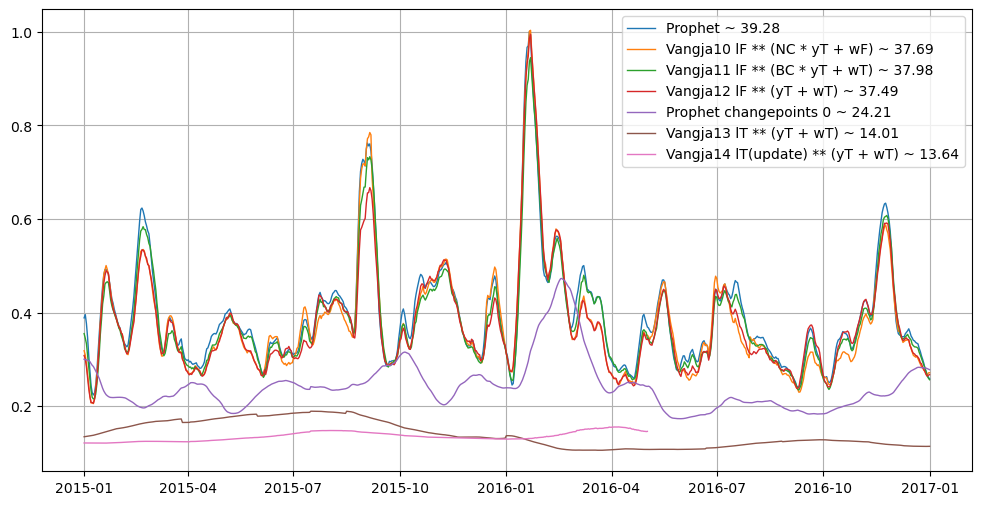

In [10]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
dates = []
dates2 = []
vangja_dates = []
vangja2_dates = []
vangja3_dates = []
vangja4_dates = []
vangja5_dates = []
mapes = []
mapes2 = []
vangja_mapes = []
vangja2_mapes = []
vangja3_mapes = []
vangja4_mapes = []
vangja5_mapes = []

index = None

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    index_1 = pd.read_csv(csv_path, index_col=0).index
    index_2 = pd.read_csv(vangja_path, index_col=0).index
    index_1 = index_1.intersection(index_2)
    if index is None:
        index = index_1

    index = index.intersection(index_1)

print(len(index))
prophet_metrics_per_ticker = {}
vangja_metrics_per_ticker = {}

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    csv2_path = Path("./") / "out" / "prophet" / "test2" / f"prophet_{point_str}_multiplicative_lt0_w.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    vangja2_path = Path("./") / "out" / "vangja" / "test11" / f"{point_str}.csv"
    vangja3_path = Path("./") / "out" / "vangja" / "test12" / f"{point_str}.csv"
    vangja4_path = Path("./") / "out" / "vangja" / "test13" / f"{point_str}.csv"
    vangja5_path = Path("./") / "out" / "vangja" / "test14" / f"{point_str}.csv"

    if not csv_path.is_file():
        continue

    dates.append(point)
    prophet_metrics = pd.read_csv(csv_path, index_col=0)
    mapes.append(prophet_metrics["mape"].mean())

    if not vangja_path.is_file():
        continue

    vangja_metrics = pd.read_csv(vangja_path, index_col=0)
    vangja_dates.append(point)
    vangja_mapes.append(vangja_metrics["mape"].mean())

    # for ticker in index:
    #     prophet_metrics_per_ticker[ticker] = prophet_metrics_per_ticker.get(
    #         ticker, []
    #     ) + [prophet_metrics.loc[ticker]["mape"]]
    #     vangja_metrics_per_ticker[ticker] = vangja_metrics_per_ticker.get(
    #         ticker, []
    #     ) + [vangja_metrics.loc[ticker]["mape"]]

    if not vangja2_path.is_file():
        continue

    vangja2_metrics = pd.read_csv(vangja2_path, index_col=0)
    vangja2_dates.append(point)
    vangja2_mapes.append(vangja2_metrics["mape"].mean())

    if not vangja3_path.is_file():
        continue

    vangja3_metrics = pd.read_csv(vangja3_path, index_col=0)
    vangja3_dates.append(point)
    vangja3_mapes.append(vangja3_metrics["mape"].mean())

    if not csv2_path.is_file():
        continue

    dates2.append(point)
    prophet_metrics = pd.read_csv(csv2_path, index_col=0)
    mapes2.append(prophet_metrics["mape"].mean())

    if not vangja4_path.is_file():
        continue

    vangja4_metrics = pd.read_csv(vangja4_path, index_col=0)
    vangja4_dates.append(point)
    vangja4_mapes.append(vangja4_metrics["mape"].mean())

    

    if not vangja5_path.is_file():
        continue

    vangja5_metrics = pd.read_csv(vangja5_path, index_col=0)
    vangja5_dates.append(point)
    vangja5_mapes.append(vangja5_metrics["mape"].mean()) 

plt.figure(figsize=(12, 6))
plt.plot(dates, mapes, lw=1, label=f"Prophet ~ {100 * sum(mapes) / len(mapes):.2f}")
plt.plot(
    vangja_dates,
    vangja_mapes,
    lw=1,
    label=f"Vangja10 lF ** (NC * yT + wF) ~ {100 * sum(vangja_mapes) / len(vangja_mapes):.2f}",
)
plt.plot(
    vangja2_dates,
    vangja2_mapes,
    lw=1,
    label=f"Vangja11 lF ** (BC * yT + wT) ~ {100 * sum(vangja2_mapes) / len(vangja2_mapes):.2f}",
)
plt.plot(
    vangja3_dates,
    vangja3_mapes,
    lw=1,
    label=f"Vangja12 lF ** (yT + wT) ~ {100 * sum(vangja3_mapes) / len(vangja3_mapes):.2f}",
)

plt.plot(dates2, mapes2, lw=1, label=f"Prophet changepoints 0 ~ {100 * sum(mapes2) / len(mapes2):.2f}")
plt.plot(
    vangja4_dates,
    vangja4_mapes,
    lw=1,
    label=f"Vangja13 lT ** (yT + wT) ~ {100 * sum(vangja4_mapes) / len(vangja4_mapes):.2f}",
)
plt.plot(
    vangja5_dates,
    vangja5_mapes,
    lw=1,
    label=f"Vangja14 lT(update) ** (yT + wT) ~ {100 * sum(vangja5_mapes) / len(vangja5_mapes):.2f}",
)
plt.grid()
plt.legend()

In [39]:
(pd.DataFrame(prophet_metrics_per_ticker).mean() - pd.DataFrame(vangja_metrics_per_ticker).mean()).sort_values(ascending=False).iloc[:380]

CF      0.080433
UAA     0.067014
WYNN    0.061479
MOS     0.057299
FCX     0.052467
          ...   
DHR     0.003513
EIX     0.003484
RSG     0.003438
PSX     0.003223
LYV     0.003138
Length: 380, dtype: float64

In [56]:
ti = pd.DataFrame(prophet_metrics_per_ticker).mean().sort_values().index

In [61]:
pd.DataFrame(prophet_metrics_per_ticker).mean()["UNH"], pd.DataFrame(vangja_metrics_per_ticker).mean()["UNH"]

(0.24384666203119232, 0.21951790229681753)

In [69]:
(
    (
        pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
        - pd.DataFrame(vangja_metrics_per_ticker).mean().loc[ti]
    )
    / pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
).sort_values(ascending=False)

UNH     0.099771
CF      0.096638
LEG     0.093062
CAH     0.091181
TPR     0.089200
          ...   
MA     -0.031540
PG     -0.034188
CTAS   -0.034577
V      -0.046210
TAP    -0.054254
Length: 442, dtype: float64

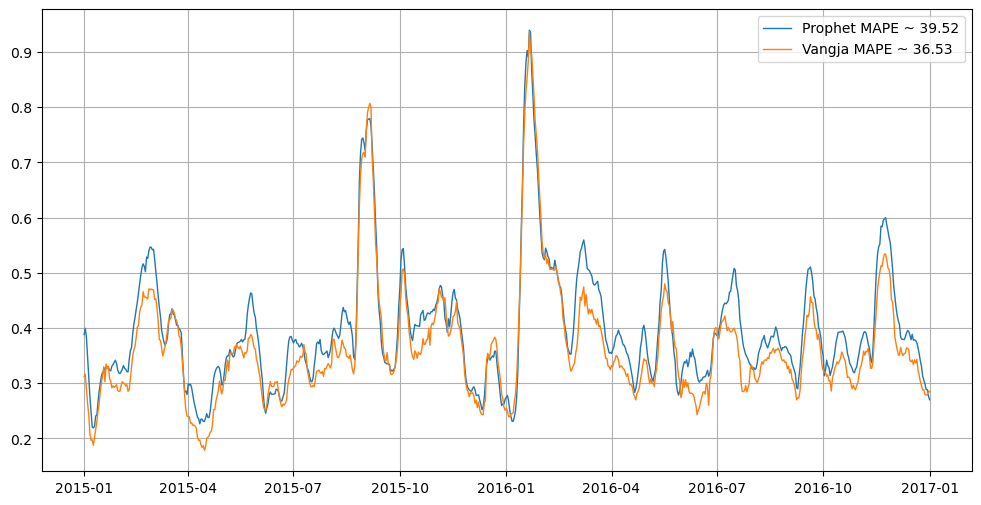

In [72]:

# best = (pd.DataFrame(prophet_metrics_per_ticker).mean() - pd.DataFrame(vangja_metrics_per_ticker).mean()).sort_values(ascending=False).iloc[:200].index
best = (
    (
        pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
        - pd.DataFrame(vangja_metrics_per_ticker).mean().loc[ti]
    )
    / pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
).sort_values(ascending=False).iloc[:50].index
dates = []
vangja_dates = []
mapes = []
vangja_mapes = []

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    dates.append(point)
    prophet_metrics = pd.read_csv(csv_path, index_col=0).loc[best]
    mapes.append(prophet_metrics["mape"].mean())
    if not vangja_path.is_file():
        continue

    vangja_metrics = pd.read_csv(vangja_path, index_col=0).loc[best]
    vangja_dates.append(point)
    vangja_mapes.append(vangja_metrics["mape"].mean())

plt.figure(figsize=(12, 6))
plt.plot(dates, mapes, lw=1, label=f"Prophet MAPE ~ {100 * sum(mapes) / len(mapes):.2f}")
plt.plot(vangja_dates, vangja_mapes, lw=1, label=f"Vangja MAPE ~ {100 * sum(vangja_mapes) / len(vangja_mapes):.2f}")
plt.grid()
plt.legend()

In [37]:
prophet_metrics_per_ticker["NRG"]

[0.6602629960815104,
 0.8690505326626856,
 0.664686055294643,
 1.0929526245791368,
 0.9524554900491292]

In [186]:
pd.DataFrame(vangja_metrics_per_ticker).mean().sort_values()

CLX     0.120702
RSG     0.154542
PEP     0.183628
T       0.188831
LMT     0.191420
          ...   
CF      0.986732
NCLH    1.021120
MU      1.025952
WMB     1.117796
FCX     1.489121
Length: 442, dtype: float64

In [24]:
pd.Series(mapes).describe()

count    664.000000
mean       0.393368
std        0.117633
min        0.224099
25%        0.316248
50%        0.365206
75%        0.437891
max        1.000289
dtype: float64

In [25]:
pd.Series(vangja_mapes).describe()

count    664.000000
mean       0.376859
std        0.120885
min        0.205629
25%        0.297395
50%        0.348706
75%        0.414936
max        1.002883
dtype: float64

In [63]:
idx = -3
mapes[idx], vangja_mapes[idx]

(0.29075288763021745, 0.28838827693962354)